# Inference Time

In [ ]:
from dust3r.inference import inference, load_model
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

import time
import numpy as np

model_path = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
device = 'cuda:6'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300

model = load_model(model_path, device)
# load_images can take a list of images or a directory
images = load_images(['croco/assets/Chateau1.png', 'croco/assets/Chateau2.png'], size=512)

In [ ]:
batch = []
for _ in range(100):
    times = []
    t0 = time.time()
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    t1 = time.time()
    times.append(t1 - t0)
    output, ts = inference(pairs, model, device, batch_size=batch_size, return_times=True)
    times += ts
    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']
    # here, view1, pred1, view2, pred2 are dicts of lists of len(2)
    #  -> because we symmetrize we have (im1, im2) and (im2, im1) pairs
    # in each view you have:
    # an integer image identifier: view1['idx'] and view2['idx']
    # the img: view1['img'] and view2['img']
    # the image shape: view1['true_shape'] and view2['true_shape']
    # an instance string output by the dataloader: view1['instance'] and view2['instance']
    # pred1 and pred2 contains the confidence values: pred1['conf'] and pred2['conf']
    # pred1 contains 3D points for view1['img'] in view1['img'] space: pred1['pts3d']
    # pred2 contains 3D points for view2['img'] in view1['img'] space: pred2['pts3d_in_other_view']

    # next we'll use the global_aligner to align the predictions
    # depending on your task, you may be fine with the raw output and not need it
    # with only two input images, you could use GlobalAlignerMode.PairViewer: it would just convert the output
    # if using GlobalAlignerMode.PairViewer, no need to run compute_global_alignment
    t0 = time.time()
    scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
    t1 = time.time()
    times.append(t1 - t0)
    loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

    # retrieve useful values from scene:
    imgs = scene.imgs
    t0 = time.time()
    focals = scene.get_focals()
    poses = scene.get_im_poses()
    pts3d = scene.get_pts3d()
    confidence_masks = scene.get_masks()
    t1 = time.time()
    times.append(t1 - t0)
    batch.append(times)

batch = np.array(batch)
print('Pairing, Encoder, Decoder, Downstream Head')
print(f'batch times: {batch.mean(0)}')
print(f'batch times std: {batch.std(0)}')
print(f'% of time spent in each step: {batch.mean(0) / batch.mean(0).sum() * 100}')

    Pairing         Encoder        Decoder        Head           Scene          Scene Parsing
    17.82us         19.93ms        26.93ms        11.24ms        72.59ms        6.69ms
    0.01%           14.51%         19.59%         8.18%          52.83%         4.87%

    Pairing         Encoder        Decoder        Head           Scene          Scene Parsing
    19.42us         16.71ms        23.73ms        14.48ms        20.95ms        6.98ms
    6.88us          2.81ms         2.23ms         2.51ms         9.37ms         1.19ms
    0.02%           20.17%         28.64%         17.48%         25.28%         8.42%

In [ ]:
0.01 + 14.51 + 19.59 + 8.18 + 52.83 + 4.87

In [ ]:
s = [16.71, 23.73, 14.48]
s = [19.93, 26.93, 11.24]

[i / sum(s) * 100 for i in s]

In [ ]:
sum(s)

# Pre-save Features

In [ ]:
from PIL import Image

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000001.jpg')

In [ ]:
import json

with open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/selected_seqs_train.json') as f:
    train = json.load(f)
with open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/selected_seqs_test.json') as f:
    test = json.load(f)

In [ ]:
train

In [ ]:
test

In [ ]:
[(i, train[i].keys()) for i in train.keys()]

In [ ]:
from jsondiff import diff
diff(train, test)

In [ ]:
import glob

list_1 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.jpg")
list_2 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.npy")
list_3 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.npz")
len(list_1), len(list_2), len(list_3)

In [ ]:
list_1 = [f[:-4] for f in list_1]
list_2 = [f[:-4] for f in list_2]
list_3 = [f[:-4] for f in list_3]

In [ ]:
s = set(list_2)
temp = [x for x in list_1 if x not in s]
print(sorted(temp))
len(temp)

In [ ]:
list_1 == list_2, list_1 == list_3, list_2 == list_3

In [ ]:
list_2


In [ ]:
import os

for i in list_2:
    os.remove(i)
    continue

In [ ]:
import torch
from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model

model = AsymmetricCroCo3DStereo(
    pos_embed='RoPE100',
    img_size=(224, 224),
    head_type='linear',
    output_mode='pts3d', 
    depth_mode=('exp', -inf, inf), 
    conf_mode=('exp', 1, inf), 
    enc_embed_dim=192, 
    enc_depth=12, 
    enc_num_heads=3, 
    dec_embed_dim=768, 
    dec_depth=12, 
    dec_num_heads=12)

In [ ]:
train_modules = [model.patch_embed, model.mask_generator, model.rope, model.enc_blocks, model.enc_norm]
train_params = torch.nn.ParameterList([p for m in train_modules for p in m.parameters()])

In [ ]:
opt = torch.optim.Adam(train_params, lr=1e-3)

# Build Model

In [ ]:
import torch
from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model
from dust3r.inference import load_model

In [ ]:
MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"
MODEL_NEW = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"

CKPT = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
CKPT_KD = "log/train_10/checkpoint-best.pth"
CKPT_NEW = "checkpoints/DUSt3R_ViTSmall_BaseDecoder_512_dpt_kd.pth"

In [ ]:
model = load_model(CKPT, 'cpu')

In [ ]:
model_kd = eval(MODEL_KD)
ckpt_kd = torch.load(CKPT_KD)['model']
print(model_kd.load_state_dict(ckpt_kd, strict=True))

In [ ]:
model_new = eval(MODEL_NEW)

In [ ]:
module_list = ['decoder_embed', 'dec_norm', 'dec_blocks', 'dec_norm', 'dec_blocks2', 'downstream_head1', 'downstream_head2']
module_list_kd = ['patch_embed', 'mask_generator', 'rope', 'enc_blocks', 'enc_norm', 'adapter']

In [ ]:
for m in module_list:
    getattr(model_new, m).load_state_dict(getattr(model, m).state_dict(), strict=True)
model_new.mask_token = model.mask_token

for m in module_list_kd:
    getattr(model_new, m).load_state_dict(getattr(model_kd, m).state_dict(), strict=True)

In [ ]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismatch found at', key_item_1[0], key_item_2[0])
            else:
                print('Error at', key_item_1[0], key_item_2[0])
            return False
    if models_differ == 0:
        # print('Models match perfectly! :)')
        return True

In [ ]:
for m, k in zip(model_kd.named_children(), model_new.named_children()):
    print(m[0], compare_models(m[1],k[1]), '\n')

In [ ]:
l = [x for x in model_new.named_children() if x[0] != 'adapter']
for m, k in zip(model.named_children(), l):
    print(m[0], compare_models(m[1],k[1]), '\n')
    # except:
    #     print(m[0], "Size Mismatch")

In [ ]:
torch.save(model_new.state_dict(), CKPT_NEW)

In [ ]:
ckpt_new = torch.load(CKPT_NEW)
print(model_kd.load_state_dict(ckpt_new, strict=False))

In [ ]:
def build_model_enc_dec(model_str, device):
    teacher = load_model("checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth", device)
    teacher.eval()

    model = eval(model_str)
    model.to(device)
    model.eval()

    module_list = ['decoder_embed', 'dec_norm', 'dec_blocks', 'dec_norm', 'dec_blocks2', 'downstream_head1', 'downstream_head2']
    for m in module_list:
        getattr(model, m).load_state_dict(getattr(teacher, m).state_dict(), strict=True)

    return teacher, model

In [ ]:
teacher, model = build_model_enc_dec(MODEL_NEW, 'cpu')

In [ ]:
l = [x for x in model.named_children() if x[0] != 'adapter']
for m, k in zip(teacher.named_children(), l):
    print(m[0], compare_models(m[1],k[1]), '\n')

In [ ]:
from PIL import Image

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000060.jpg')

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000030.jpg')

In [ ]:
import torch

In [ ]:
w0 = torch.load('log/train_w_0/checkpoint-1.pth', map_location='cpu')['model']
w1 = torch.load('log/train_x_1/checkpoint-2.pth', map_location='cpu')['model']
w2 = torch.load('checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth', map_location='cpu')['model']

In [ ]:
h0 = torch.load('log_kd/log_h/ckpt/iter_2475.pth', map_location='cpu')
h1 = torch.load('log_kd/log_h/ckpt/iter_4950.pth', map_location='cpu')

In [ ]:
for i, j in zip(w2.items(), w0.items()):
    if torch.equal(i[1], j[1]):
        print(i[0], torch.equal(i[1], j[1]))

In [ ]:
w0['model']['mask_token']

In [ ]:
import torch
w = torch.load('log/train_10/checkpoint-last.pth')

In [ ]:
w.keys()

In [ ]:
w['best_so_far']

# Habitat MP3D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import cv2, numpy as np
import matplotlib.pyplot as plt

# i = cv2.imread('/ssd1/wenyan/scannetpp_processed/d6d9ddb03f/depths/DSC05114.png')
i = cv2.imread('/mnt/wenyan/scannetpp_processed/d6d9ddb03f/depths/DSC05114.png')
i = i * 255.0 / i.max()
plt.imshow(i / 255.0, cmap='inferno')

In [ ]:
i.min(), i.max()

# ScanNet++ Splits

In [ ]:
import json
import os

In [ ]:
BASE_PATH = '/ssd1/wenyan/scannetpp_processed'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    frames = os.listdir(os.path.join(base_path, scene, 'images'))
    return [int(f.split('.')[0].split("DSC")[1].lstrip("0")) for f in frames if f.endswith('.JPG')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [ ]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [ ]:
from dust3r.datasets import ScanNet

dataset = ScanNet(split='train', ROOT='/ssd1/wenyan/scannetpp_processed', aug_crop=16, mask_bg='rand', resolution=224)

In [ ]:
for i in dataset:
    print(i)
    break

# DL3DV Splits

In [ ]:
import json
import os

In [ ]:
BASE_PATH = '/ssd1/sa58728/dust3r/data/DL3DV-10K/'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    frames = os.listdir(os.path.join(base_path, scene, 'gaussian_splat/images_4'))
    return [int(f.split('.')[0].split("frame_")[1].lstrip("0")) for f in frames if f.endswith('.png')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [ ]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [ ]:
from dust3r.datasets import DL3DV

dataset = DL3DV(split='train', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', aug_crop=16, mask_bg='rand', resolution=224)

for i in dataset:
    print(i[0]['img'].shape)
    break

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(i[0]['img'][0])

# MegaDepth Splits

In [ ]:
import json
import os

In [ ]:
BASE_PATH = '/ssd1/sa58728/dust3r/data/MegaDepth_v1/'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    if scene.endswith('list'):
        return []
    try:
        frames = os.listdir(os.path.join(base_path, scene, 'dense0/imgs/'))
    except:
        frames = os.listdir(os.path.join(base_path, scene, 'dense1/imgs/'))
    return [f.split('.')[0] for f in frames if f.endswith('.jpg')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [ ]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [ ]:
from dust3r.datasets import MegaDepth

dataset = MegaDepth(split='train', ROOT='/ssd1/sa58728/dust3r/data/MegaDepth_v1', aug_crop=16, mask_bg='rand', resolution=224)

for i in dataset:
    print(i[0]['img'].shape)
    break

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(i[0]['img'][0])

# Gaussian Frames

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [ ]:
MEAN = 3
STD = 9

m, n = [], []
for i in range(100000):
    m.append(int(rng.normal(loc=0.0, scale=STD)) + MEAN)
    n.append(int(rng.normal(loc=0.0, scale=STD)))
o = [m - n for m, n in zip(m, n)] + [n - m for m, n in zip(m, n)]

In [ ]:
# v2
bins = plt.hist(o, bins=range(-40,6), align='left', density=True, cumulative=False)
# plt.xticks(np.arange(-21, 22, 3))
# plt.yticks(np.arange(0, 1.1, 0.05))
# plt.grid(True, alpha=0.3)
# plt.hlines(0.025, -20, 22, color='r', alpha=0.5)
# plt.hlines(0.975, -20, 22, color='r', alpha=0.5)
# plt.hlines(0.25, -20, 22, color='r', alpha=0.5)
# plt.hlines(0.75, -20, 22, color='r', alpha=0.5)
# plt.vlines(-9, 0, 1, color='r', alpha=0.5)
# plt.vlines(-3, 0, 1, color='r', alpha=0.5)
# plt.vlines(3, 0, 1, color='r', alpha=0.5)
# plt.vlines(9, 0, 1, color='r', alpha=0.5)
# plt.show()

In [ ]:
bins = plt.hist(o, bins=range(-40,10), align='left', density=True, cumulative=False)

In [ ]:
import itertools

MEAN = 3
STD = 1
last = 10000
o = []

combinations = [
    (i, j)
    for i, j in itertools.combinations(range(100), 2)
    if abs(i-j) == 3
]
# combinations = [(i, j)
#                     for i, j in itertools.combinations(range(100), 2)
#                     if 0 < abs(i-j) <= 30 and abs(i-j) % 5 == 0
#                     ]

for idx in range(last):
    im1_idx, im2_idx = combinations[idx % len(combinations)]
    imgs_idxs = [max(0, min(im_idx + int(rng.normal(loc=0.0, scale=STD)), last)) for im_idx in [im2_idx, im1_idx]]
    # imgs_idxs = [max(0, min(im_idx + rng.integers(-4, 5), last)) for im_idx in [im2_idx, im1_idx]]
    o.append(imgs_idxs[1] - imgs_idxs[0])

In [ ]:
combinations

In [ ]:
# v1
bins = plt.hist(o, bins=range(-24,30), align='left', density=True, cumulative=True)
plt.xticks(np.arange(-20, 22, 5))
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True, alpha=0.3)
plt.hlines(0.025, -20, 22, color='r', alpha=0.5)
plt.hlines(0.975, -20, 22, color='r', alpha=0.5)
plt.hlines(0.25, -20, 22, color='r', alpha=0.5)
plt.hlines(0.75, -20, 22, color='r', alpha=0.5)
plt.vlines(-15, 0, 1, color='r', alpha=0.5)
plt.vlines(-5, 0, 1, color='r', alpha=0.5)
plt.vlines(15, 0, 1, color='r', alpha=0.5)
plt.vlines(5, 0, 1, color='r', alpha=0.5)


In [ ]:
bins

In [ ]:
import itertools

combinations = [
    (i, j)
    for i, j in itertools.combinations(range(1000), 2)
    if 0 < abs(i-j) <= 30 and abs(i-j) % 5 == 0
]
o = []
for i, j in combinations:
    imgs_idxs = [max(0, min(im_idx + rng.integers(-4, 5), 1000)) for im_idx in [i, j]]
    o.append(imgs_idxs[0] - imgs_idxs[1])
    o.append(imgs_idxs[1] - imgs_idxs[0])

In [ ]:
bins = plt.hist(o, bins=range(-40,40), align='left', density=True, cumulative=True)
plt.xticks(np.arange(-40, 40, 5))
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True, alpha=0.3)
plt.hlines(0.025, -40, 40, color='r', alpha=0.5)
plt.hlines(0.975, -40, 40, color='r', alpha=0.5)
plt.hlines(0.25, -40, 40, color='r', alpha=0.5)
plt.hlines(0.75, -40, 40, color='r', alpha=0.5)
plt.vlines(-32, 0, 1, color='r', alpha=0.5)
plt.vlines(-18, 0, 1, color='r', alpha=0.5)
plt.vlines(18, 0, 1, color='r', alpha=0.5)
plt.vlines(32, 0, 1, color='r', alpha=0.5)

# Save Pair Samples

In [ ]:
import os
from dust3r.datasets import get_data_loader  # noqa
from torchvision.utils import save_image

OUT_FOLDER = "pairs"
DATASET = "ScanNet"
GAUSSIAN = True

if DATASET == "Co3D":
    TRAIN_DATA = f"1000 @ Co3d(split='train', ROOT='/ssd1/wenyan/co3d_2_cat_processed', aug_crop=16, mask_bg='rand', resolution=224, transform=ImgNorm, gaussian_frames={GAUSSIAN})"
elif DATASET == "ScanNet":
    TRAIN_DATA = f"1000 @ ScanNetpp(split='train', ROOT='/mnt/vita-nas/scannetpp_processed', aug_crop=16, resolution=224, transform=ImgNorm)"
elif DATASET == "DL3DV":
    TRAIN_DATA = f"1000 @ DL3DV(split='train', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', aug_crop=16, mask_bg='rand', resolution=224, transform=ImgNorm, gaussian_frames={GAUSSIAN})"

loader = get_data_loader(
    TRAIN_DATA,
    batch_size=1,
    num_workers=4,
    pin_mem=True,
    shuffle=True,
    drop_last=True
)

if hasattr(loader, 'dataset') and hasattr(loader.dataset, 'set_epoch'):
    loader.dataset.set_epoch(0)
if hasattr(loader, 'sampler') and hasattr(loader.sampler, 'set_epoch'):
    loader.sampler.set_epoch(0)

In [ ]:
def save_image_pair(pair, plot=False):
    name1 = pair[0]['instance'][0].split('.')[0]
    name2 = pair[1]['instance'][0].split('.')[0]
    name = f"{name1}_{name2}"
    os.makedirs(f"{OUT_FOLDER}/{DATASET}/{name}", exist_ok=True)

    img1 = ((pair[0]['img'][0] * 0.5) + 0.5)
    img2 = ((pair[1]['img'][0] * 0.5) + 0.5)

    save_image(img1, f"{OUT_FOLDER}/{DATASET}/{name}/{name1}.png")
    save_image(img2, f"{OUT_FOLDER}/{DATASET}/{name}/{name2}.png")

    if plot:
        plt.imshow(img1.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

        plt.imshow(img2.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

In [ ]:
for i, pair in enumerate(loader, 1):
    save_image_pair(pair)
    if i == 10:
        break

In [ ]:
from PIL import Image
Image.open("/mnt/vita-nas/scannetpp_processed/116456116b/images/DSC09535.jpg")

In [ ]:
import numpy as np

with np.load(os.path.join('/mnt/vita-nas/scannetpp_processed', 'all_metadata.npz')) as data:
    scenes = data['scenes']
    sceneids = data['sceneids']
    images = data['images']
    intrinsics = data['intrinsics'].astype(np.float32)
    trajectories = data['trajectories'].astype(np.float32)
    pairs = data['pairs'][:, :2].astype(int)

In [ ]:
pairs

# RoMa

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
# RoMa
import torch.nn.functional as F
from RoMa.roma.utils.utils import tensor_to_pil
from RoMa.roma import roma_outdoor
# DUSt3R
# torch.backends.cuda.matmul.allow_tf32 = True  # for gpu >= Ampere and pytorch >= 1.12
from dust3r.losses import *  # noqa: F401, needed when loading the model
from dust3r.inference import loss_of_one_batch, load_model
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.utils.device import to_cpu, collate_with_cat
from misc.test_pairs import *

CKPT = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"
CKPT_KD = "log/train_2/checkpoint-best.pth"
TEST_CRITERION = "ConfLoss(Regr3D(L21, norm_mode='avg_dis', kd=True), alpha=0.2) + Regr3D_ScaleShiftInv(L21, gt_scale=True, kd=True)"

device = torch.device('cpu')
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
img_path = "test/RoMa/"
im1_path = img_path + "DSC00410.png"
im2_path = img_path + "DSC09985.png"
save_path = "./roma.jpg"

In [ ]:
# Create model
roma_model = roma_outdoor(device=device, coarse_res=224, upsample_res=224)
H, W = roma_model.get_output_resolution()

im1 = Image.open(im1_path).resize((W, H))
im2 = Image.open(im2_path).resize((W, H))

# teacher, model = load_pretrained(MODEL_KD, CKPT, CKPT_KD, device)
test_criterion = eval(TEST_CRITERION).to(device)

In [ ]:
images = load_images(img_path, size=224)
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=False)

with torch.no_grad():
    result = loss_of_one_batch(collate_with_cat(pairs), teacher, test_criterion, device,
                            symmetrize_batch=False, features=True,
                            kd=True, kd_out=True, teacher=teacher, lmd=10)
    
result = to_cpu(result)
loss_value, loss_details = result['loss']  # criterion returns two values
loss_details['loss'] = loss_value.item()
print(f"Details: {loss_details}")

In [ ]:
result['pred1']['pts3d'].shape, result['pred2']['pts3d_in_other_view'].shape

In [ ]:
# Match
warp, certainty = roma_model.match(im1_path, im2_path, device=device)
warp, certainty = warp.reshape(-1, 2*H*W, 4), certainty.reshape(-1, 2*H*W)
warp_filter = warp[certainty > 0.55]
# out, valid = roma_model.sample(warp, certainty)
kptsA, kptsB = roma_model.to_pixel_coordinates(warp_filter, H, W, H, W)
kptsA, kptsB = kptsA.cpu().numpy().astype('int'), kptsB.cpu().numpy().astype('int')

In [ ]:
fig = plt.figure()
ax = plt.axes()
cert = certainty.reshape(H,2*W).cpu() > 0.1
im = ax.imshow(cert)
plt.axis('off')
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
plt.show()
print(cert.float().mean()*100, cert.float().mean()*H*W)

In [ ]:
plt.hist(certainty.cpu(), bins=100, log=True)

In [ ]:
im1

In [ ]:
im2

In [ ]:
plt.hist(certainty.cpu().numpy().flatten(), cumulative=True, bins=100)
plt.hlines(90000, 0, 1, color='r', alpha=0.5)
plt.vlines(0.55, 0, 100000, color='r', alpha=0.5)

In [ ]:
warp.min(), warp.max()

In [ ]:
kptsA, kptsB = roma_model.to_pixel_coordinates(warp, H, W, H, W)

In [ ]:
kptsA.shape

In [ ]:
# Sampling not needed, but can be done with model.sample(warp, certainty)
x1 = (torch.tensor(np.array(im1)) / 255).to(device).permute(2, 0, 1)
x2 = (torch.tensor(np.array(im2)) / 255).to(device).permute(2, 0, 1)

# take only the matching part from images and copy colors (xyz values once normalized)
im1_transfer_rgb = F.grid_sample(
    x1[None], warp[:, W:, :2][None], mode="bilinear", align_corners=False
)[0]
im2_transfer_rgb = F.grid_sample(
    x2[None], warp[:,:W, 2:][None], mode="bilinear", align_corners=False
)[0]
warp_im = torch.cat((im2_transfer_rgb,im1_transfer_rgb),dim=2)
white_im = torch.ones((H,2*W),device=device)
vis_im = certainty * warp_im + (1 - certainty) * white_im
tensor_to_pil(vis_im, unnormalize=False).save(save_path)

In [ ]:
kptsB.shape

In [ ]:
i = 2500
print(kptsA[i])
plt.imshow(im1)
plt.scatter(*kptsA[i], c='r', s=10)
plt.show()
plt.imshow(im2)
plt.scatter(*kptsB[i], c='r', s=10)
plt.show()

In [ ]:
i = 1240
print(kptsA[i])
plt.imshow((pairs[0][1]['img'][0].permute(1, 2, 0)*0.5)+0.5)
plt.scatter(*kptsA[i], c='r', s=10)
plt.show()
plt.imshow((pairs[0][0]['img'][0].permute(1, 2, 0)*0.5)+0.5)
plt.scatter(*kptsB[i], c='r', s=10)
plt.show()
plt.imshow(result['pred2']['pts3d_in_other_view'][0,:,:,-1])
plt.scatter(*kptsA[i], c='r', s=10)
plt.show()
plt.imshow(result['pred1']['pts3d'][0,:,:,-1])
plt.scatter(*kptsB[i], c='r', s=10)
plt.show()

In [ ]:
result['pred1']['pts3d'][0,kptsB[:,0],kptsB[:,1]].shape


In [ ]:
p1 = result['pred1']['pts3d'][0,kptsB[:,0],kptsB[:,1]] # * valid[:,None].cpu()
p2 = result['pred2']['pts3d_in_other_view'][0,kptsA[:,0],kptsA[:,1]] # * valid[:,None].cpu()
print(p1.shape, p2.shape, (p1 - p2).abs().mean(), ((p1 - p2)**2).mean())

In [ ]:
kptsA[i].astype('int'), kptsA[i], kptsB[i].astype('int'), kptsB[i]

In [ ]:
result['pred1']['pts3d'].shape

# Batch RoMa

In [ ]:
import matplotlib.pyplot as plt
from dust3r.inference import *
from test_kd import *

H, W = 224, 224

In [ ]:
import argparse
import numpy as np
import os
import random
from collections import defaultdict
from pathlib import Path
from typing import Sized
from copy import deepcopy
import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
torch.backends.cuda.matmul.allow_tf32 = True  # for gpu >= Ampere and pytorch >= 1.12

from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model
from dust3r.datasets import get_data_loader  # noqa
from dust3r.losses import *  # noqa: F401, needed when loading the model
from dust3r.inference import loss_of_one_batch, load_model
import dust3r.utils.path_to_croco  # noqa: F401
import croco.utils.misc as misc  # noqa
from RoMa.roma import roma_outdoor

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

TEST_DATA = "Co3d(split='test', ROOT='/ssd1/sa58728/dust3r/data/co3d_subset_processed', resolution=224, seed=777, gaussian_frames=False)" # Unseen scenes
TEST_DATA += " + ScanNet(split='test', ROOT='/ssd1/wenyan/scannetpp_processed', resolution=224, seed=777, gaussian_frames=True)" # Unseen scenes
TEST_DATA += " + DL3DV(split='test', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', resolution=224, seed=777, gaussian_frames=True)" # Unseen scenes

MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"
CKPT = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
CKPT_KD = None # "checkpoints/DUSt3R_ViTSmall_BaseDecoder_512_dpt_kd.pth"
TEST_CRITERION = "ConfLoss(Regr3D(L21, norm_mode='avg_dis', kd=True), alpha=0.2) + Regr3D_ScaleShiftInv(L21, gt_scale=True, kd=True)"

def get_args_parser():
    parser = argparse.ArgumentParser('DUSt3R training', add_help=False)
    # model and criterion
    parser.add_argument('--model', default=MODEL_KD, type=str, help="string containing the model to build")
    parser.add_argument('--pretrained', default=None, help='path of a starting checkpoint') # CKPT_KD
    parser.add_argument('--test_criterion', default=TEST_CRITERION, type=str, help="test criterion")
    # dataset
    parser.add_argument('--test_dataset', default=TEST_DATA, type=str, help="testing set")
    parser.add_argument('--seed', default=777, type=int, help="Random seed")
    # others
    parser.add_argument('--num_workers', default=8, type=int)
    parser.add_argument('--world_size', default=1, type=int, help='number of distributed processes')
    parser.add_argument('--local_rank', default=0, type=int)
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')

    parser.add_argument('--eval_freq', type=int, default=1, help='Test loss evaluation frequency')
    parser.add_argument('--save_freq', default=1, type=int,
                        help='frequence (number of epochs) to save checkpoint in checkpoint-last.pth')
    parser.add_argument('--keep_freq', default=1, type=int,
                        help='frequence (number of epochs) to save checkpoint in checkpoint-%d.pth')
    parser.add_argument('--print_freq', default=1000, type=int,
                        help='frequence (number of iterations) to print infos while training')
    parser.add_argument('--teacher_path', default=CKPT, type=str, help="path to the teacher model")

    parser.add_argument('--lmd', default=10, type=float, help="kd loss weight")
    parser.add_argument('--output_dir', default='./log/train/', type=str, help="path where to save the output")
    parser.add_argument('--cuda', default=7, type=int, help="cuda device")
    parser.add_argument('--ckpt', default=None, type=str, help="resume from checkpoint") # "log/ckpt/iter_24750.pth"
    parser.add_argument('--batch_size', default=8, type=int, help="Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus")
    parser.add_argument('--accum_iter', default=1, type=int, help="Accumulate gradient iterations")
    parser.add_argument('--kd', default=True, type=bool)
    parser.add_argument('--kd_out', default=True, action='store_true', help="knowledge distillation (output)")

    return parser

def build_dataset(dataset, batch_size, num_workers, test=False):
    split = ['Train', 'Test'][test]
    print(f'Building {split} Data loader for dataset: ', dataset)
    loader = get_data_loader(dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             pin_mem=True,
                             shuffle=not (test),
                             drop_last=not (test))

    print(f"{split} dataset length: ", len(loader))
    return loader

def load_pretrained(args, device):
    teacher = load_model(args.teacher_path, device)
    teacher.eval()

    model = deepcopy(teacher)
    model.to(device)
    model.eval()

    model_kd = eval(args.model)
    model_kd.to(device)
    model_kd.eval()

    ckpt = torch.load(args.ckpt, map_location=device)
    try:
        print(model_kd.load_state_dict(ckpt['model'], strict=True))
        args.start_epoch = ckpt['epoch']
    except:
        print(model_kd.load_state_dict(ckpt, strict=True))
    del ckpt  # in case it occupies memory

    model.patch_embed = deepcopy(model_kd.patch_embed)
    model.mask_generator = deepcopy(model_kd.mask_generator)
    model.rope = deepcopy(model_kd.rope)
    model.enc_blocks = deepcopy(model_kd.enc_blocks)
    model.enc_norm = deepcopy(model_kd.enc_norm)
    model.adapter = deepcopy(model_kd.adapter)

    return teacher, model

def build_model_enc_dec(model_str, device, args):
    teacher = load_model("checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth", device)
    teacher.eval()

    if "x" in args.output_dir:
        print("Using pretrained Dust3R")
        model = load_model("checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth", device)
    else:
        print("Training from scratch")
        model = eval(model_str)

    model.to(device)
    if args.ckpt:
        ckpt = torch.load(args.ckpt)
        print(model.load_state_dict(ckpt['model'], strict=True))
        args.start_epoch = ckpt['epoch']
        model.train()

    module_list = ['decoder_embed', 'dec_blocks', 'dec_norm', 'dec_blocks2', 'downstream_head1', 'downstream_head2']
    for m in module_list:
        getattr(model, m).load_state_dict(getattr(teacher, m).state_dict(), strict=True)
        getattr(model, m).eval()
    model.mask_token = teacher.mask_token

    return teacher, model

In [ ]:
args = get_args_parser()
args = args.parse_args('')

misc.init_distributed_mode(args)

device = f"cuda:6" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True

data_loader_test = {dataset.split('(')[0]: build_dataset(dataset, args.batch_size, args.num_workers, test=True)
                    for dataset in args.test_dataset.split('+')}

# teacher, model = load_pretrained(args, device)
teacher, model = build_model_enc_dec(args.model, device, args)
roma_model = roma_outdoor(device=device, coarse_res=224, upsample_res=224)
test_criterion = eval(args.test_criterion or args.criterion).to(device)

In [ ]:
def tensor_to_plot(tensor, norm=None):
    STD = np.array([0.229, 0.224, 0.225])
    MEAN = np.array([0.485, 0.456, 0.406])
    if norm == 'roma':
        return tensor.cpu().permute(1,2,0).numpy() * STD + MEAN
    elif norm == 'dust3r':
        return (tensor.cpu().permute(1,2,0).numpy() * 0.5) + 0.5
    return tensor.cpu().permute(1,2,0).numpy()

In [ ]:
# def loss_of_one_batch(batch, model, criterion, device, symmetrize_batch=False, use_amp=False, ret=None, 
#                       return_times=False, features_only=False, features=False, 
#                       kd=False, kd_out=False, teacher=None, lmd=1, criterion_kd=torch.nn.MSELoss(),
#                       roma_model=None):
#     view1, view2 = batch
#     for view in batch:
#         for name in 'img pts3d valid_mask camera_pose camera_intrinsics F_matrix corres'.split():  # pseudo_focal
#             if name not in view:
#                 continue
#             view[name] = view[name].to(device, non_blocking=True)

#     with torch.cuda.amp.autocast(enabled=bool(use_amp)):
#         outs = model(view1, view2, return_times=return_times, features_only=features_only, features=features)
#         pred1, pred2 = outs

#     loss, loss_tot = 0, 0
#     loss_dict = {}

#     with torch.no_grad():
#         renorm_img1 = (view1['img'] * 0.5 + 0.5 - ROMA_MEAN.to(device)) / ROMA_STD.to(device)
#         renorm_img2 = (view2['img'] * 0.5 + 0.5 - ROMA_MEAN.to(device)) / ROMA_STD.to(device)
#         warp, certainty = roma_model.match(renorm_img1, renorm_img2, batched=True, device=device)
#         out, valid = roma_model.sample(warp, certainty) # THIS DOES NOT WORK WITH BATCHES
#         warp, certainty = warp.reshape(-1, 2*SIZE*SIZE, 4), certainty.reshape(-1, 2*SIZE*SIZE)
#         idxs = torch.topk(certainty, 1000, dim=-1).indices
#         certainty = certainty.gather(-1, idxs)
#         warp = warp.gather(-2, idxs.unsqueeze(-1).expand(-1, -1, 4))
#         kptsA, kptsB = roma_model.to_pixel_coordinates(warp, SIZE, SIZE, SIZE, SIZE)
#         kptsA, kptsB = kptsA.type(torch.int64), kptsB.type(torch.int64)

#     p1 = outs[0]['pts3d'].gather(1, kptsB.unsqueeze(-1).expand(-1, -1, -1, 3))
#     p2 = outs[1]['pts3d_in_other_view'].gather(1, kptsA.unsqueeze(-1).expand(-1, -1, -1, 3))

#     loss_dict['roma_mse'] = ((p1 - p2)**2).mean()
#     loss_dict['roma_mae'] = ((p1 - p2).abs()).mean()
#     loss_tot += loss_dict['roma_mse'] * lmd
#     loss = (loss_tot, loss_dict)

#     result = dict(view1=view1, view2=view2, pred1=pred1, pred2=pred2, loss=loss)
#     return result[ret] if ret else result

In [ ]:
# @torch.no_grad()
# def test_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
#                    data_loader: Sized, device: torch.device, epoch: int,
#                    args, log_writer=None, prefix='test', 
#                    kd=False, teacher=None, features=False, curr_step=0,
#                    roma_model=None):
                    
#     model.eval()
#     metric_logger = misc.MetricLogger(delimiter="  ")
#     metric_logger.meters = defaultdict(lambda: misc.SmoothedValue(window_size=9**9))
#     header = 'Test Epoch: [{}]\n>'.format(epoch)

#     if hasattr(data_loader, 'dataset') and hasattr(data_loader.dataset, 'set_epoch'):
#         data_loader.dataset.set_epoch(epoch)
#     if hasattr(data_loader, 'sampler') and hasattr(data_loader.sampler, 'set_epoch'):
#         data_loader.sampler.set_epoch(epoch)

#     for _, batch in enumerate(metric_logger.log_every(data_loader, args.print_freq, header)):
        
#         loss_tuple = loss_of_one_batch(batch, model, criterion, device,
#                                        symmetrize_batch=True, features=features, ret='loss', 
#                                        kd=kd, kd_out=args.kd_out, teacher=teacher, lmd=args.lmd,
#                                        roma_model=roma_model)
#         return loss_tuple        

#     # gather the stats from all processes
#     metric_logger.synchronize_between_processes()
#     print("Averaged stats:", metric_logger)

#     aggs = [('avg', 'global_avg'), ('med', 'median')]
#     results = {f'{k}_{tag}': getattr(meter, attr) for k, meter in metric_logger.meters.items() for tag, attr in aggs}

#     return results

In [ ]:
for test_name, testset in reversed(data_loader_test.items()):
    print(test_name)
    model.eval()
    metric_logger = misc.MetricLogger(delimiter="  ")
    metric_logger.meters = defaultdict(lambda: misc.SmoothedValue(window_size=9**9))
    header = 'Test Epoch: [{}]\n>'.format(0)

    if hasattr(testset, 'dataset') and hasattr(testset.dataset, 'set_epoch'):
        testset.dataset.set_epoch(0)
    if hasattr(testset, 'sampler') and hasattr(testset.sampler, 'set_epoch'):
        testset.sampler.set_epoch(0)

    for _, batch in enumerate(metric_logger.log_every(testset, args.print_freq, header)):
        view1, view2 = batch
        for view in batch:
            for name in 'img pts3d valid_mask camera_pose camera_intrinsics F_matrix corres'.split():  # pseudo_focal
                if name not in view:
                    continue
                view[name] = view[name].to(device, non_blocking=True)

        with torch.no_grad():
            outs = teacher(view1, view2, return_times=False, features_only=False, features=True)
            pred1, pred2 = outs

        loss, loss_tot = 0, 0
        loss_dict = {}

        renorm_img1 = (view1['img'] * 0.5 + 0.5 - ROMA_MEAN.to(device)) / ROMA_STD.to(device)  
        with torch.no_grad():
            renorm_img2 = (view2['img'] * 0.5 + 0.5 - ROMA_MEAN.to(device)) / ROMA_STD.to(device)
        warp, certainty = roma_model.match(renorm_img1, renorm_img2, batched=True, device=device)
        warp, certainty = warp.reshape(-1, 2*H*W, 4), certainty.reshape(-1, 2*H*W)
        kptsA, kptsB = roma_model.to_pixel_coordinates(warp, H, W, H, W)
        kptsA, kptsB = kptsA.type(torch.int64), kptsB.type(torch.int64)
        kptsA, kptsB = kptsA.reshape(-1,H,2*W,2), kptsB.reshape(-1,H,2*W,2)

        kpts1 = kptsA[:,:,:W,:] # B, H, W, 2
        kpts2 = kptsB[:,:,:W,:] # B, H, W, 2
        pred1 = outs[0]['pts3d'] # -> kpts1
        pred2 = outs[1]['pts3d_in_other_view'] # -> kpts2
        kpts1, kpts2 = kpts1.reshape(-1,H*W,2), kpts2.reshape(-1,H*W,2)
        kpts1_flat = torch.from_numpy(np.ravel_multi_index(kpts1.cpu().permute(-1,0,1).numpy(), (H, W), order='F')).to(device)
        kpts2_flat = torch.from_numpy(np.ravel_multi_index(kpts2.cpu().permute(-1,0,1).numpy(), (H, W), order='F')).to(device)
        pred1_flat = pred1.reshape(-1, H*W, 3)
        pred2_flat = pred2.reshape(-1, H*W, 3)
        p1 = pred1_flat.gather(1, kpts1_flat.unsqueeze(-1).expand(-1,-1,3))
        p2 = pred2_flat.gather(1, kpts2_flat.unsqueeze(-1).expand(-1,-1,3))

        cert = (certainty.reshape(-1,H,2*W)[:,:,:W].reshape(-1,H*W) > 0.5).float()
        p1c = p1 * cert.unsqueeze(-1)
        p2c = p2 * cert.unsqueeze(-1)

        loss_dict['roma_mse'] = ((p1c - p2c)**2).mean() / cert.mean()
        loss_dict['roma_mae'] = (p1c - p2c).abs().mean() / cert.mean()
        loss_tot += loss_dict['roma_mse'] * 10000
        loss = (loss_tot, loss_dict)

        result = dict(view1=view1, view2=view2, pred1=pred1, pred2=pred2, loss=loss)
        break
    break

In [ ]:
loss

In [ ]:
i = 26545
c1 = kptsA.reshape(-1,2*W*H,2)[0,i]
print(c1)
print(pred1[0, c1[1], c1[0]]) # reverse coordinates
plt.imshow(tensor_to_plot(batch[0]['img'][0], norm='dust3r'))
plt.scatter(*c1.cpu(), c='r', s=10)
plt.show()
c2 = kptsB.reshape(-1,2*W*H,2)[0,i]
print(c2)
print(pred2[0, c2[1], c2[0]]) # reverse coordinates
plt.imshow(tensor_to_plot(batch[1]['img'][0], norm='dust3r'))
plt.scatter(*c2.cpu(), c='r', s=10)
plt.show()

In [ ]:
i = 45802
c1 = kptsA.reshape(-1,2*W*H,2)[0,i]
print(c1)
print(pred1[0, c1[1], c1[0]]) # reverse coordinates
plt.imshow(pred1[0,...,-1].cpu())
plt.scatter(*c1.cpu(), c='r', s=10)
plt.show()
c2 = kptsB.reshape(-1,2*W*H,2)[0,i]
print(c2)
print(pred2[0, c2[1], c2[0]]) # reverse coordinates
plt.imshow(pred2[0,...,-1].cpu())
plt.scatter(*c2.cpu(), c='r', s=10)
plt.show()

print(pred1[0,*kptsA.reshape(-1,2*H*W,2)[0,i],:].cpu(), pred2[0,*kptsB.reshape(-1,2*H*W,2)[0,i],:].cpu())
print(((pred1[0, c1[1], c1[0]] - pred2[0, c2[1], c2[0]])**2).mean())
print(((pred1[0, c1[1], c1[0]] - pred2[0, c2[1], c2[0]]).abs()).mean())

In [ ]:
plt.imshow(cert.reshape(-1,H,W)[0].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(warp.reshape(-1,H,2*W,4)[0,...,3].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(kptsA[0,...,0].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(kptsB[0,...,1].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
kpts1 = kptsA[:,:,:W,:] # B, H, W, 2
kpts2 = kptsB[:,:,:W,:] # B, H, W, 2

In [ ]:
kpts1.shape

In [ ]:
plt.imshow(kpts2[0,...,1].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
kpts1, kpts2 = kpts1.reshape(-1,H*W,2), kpts2.reshape(-1,H*W,2)
kpts1_flat = torch.from_numpy(np.ravel_multi_index(kpts1.cpu().permute(-1,0,1).numpy(), (H, W), order='F')).to(device)
kpts2_flat = torch.from_numpy(np.ravel_multi_index(kpts2.cpu().permute(-1,0,1).numpy(), (H, W), order='F')).to(device)
pred1_flat = pred1.reshape(-1, H*W, 3)
pred2_flat = pred2.reshape(-1, H*W, 3)

In [ ]:
plt.imshow(kpts2_flat.reshape(-1,H,W)[0,...].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
kpts1_flat.shape, kpts2_flat.shape, pred1_flat.shape, pred2_flat.shape

In [ ]:
p1 = pred1_flat.gather(1, kpts1_flat.unsqueeze(-1).expand(-1,-1,3))
p2 = pred2_flat.gather(1, kpts2_flat.unsqueeze(-1).expand(-1,-1,3))

In [ ]:
p1.shape

In [ ]:
((p1 - p2)**2).mean(), (p1 - p2).abs().mean()

In [ ]:
cert = (certainty.reshape(-1,H,2*W)[:,:,:W].reshape(-1,H*W) > 0.5).float()
p1c = p1 * cert.unsqueeze(-1)
p2c = p2 * cert.unsqueeze(-1)

In [ ]:
((p1c - p2c)**2).mean() / cert.mean(), (p1c - p2c).abs().mean() / cert.mean()

In [ ]:
torch.topk(certainty[0], 100).indices

In [ ]:
i = 45802
c1 = kptsA.reshape(-1,2*W*H,2)[0,i]
print(c1)
print(p1.reshape(-1,H,W,3)[0, c1[1], c1[0]]) # reverse coordinates
plt.imshow(p1.reshape(-1,H,W,3)[0,:,:,-1].cpu().numpy())
plt.scatter(*c1.cpu(), c='r', s=10)
plt.colorbar()
plt.show()

print(p2.reshape(-1,H,W,3)[0, c1[1], c1[0]]) # reverse coordinates
plt.imshow(p2.reshape(-1,H,W,3)[0,:,:,-1].cpu().numpy())
plt.scatter(*c1.cpu(), c='r', s=10)
plt.colorbar()
plt.show()

print(pred1[0, c1[1], c1[0]].cpu(), pred2[0, c2[1], c2[0]].cpu())
print(((pred1[0, c1[1], c1[0]] - pred2[0, c2[1], c2[0]])**2).mean())
print(((pred1[0, c1[1], c1[0]] - pred2[0, c2[1], c2[0]]).abs()).mean())

In [ ]:
diff = p2 - p1
plt.imshow(diff.reshape(-1,H,W,3)[0,:,:,2].cpu().numpy())
plt.colorbar()
plt.show()

In [ ]:
diff.min(), diff.max(), (diff**2).mean()





# RoMa Loss Check

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import argparse
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict
import torch
from dust3r.datasets import get_data_loader  # noqa
from dust3r.inference import load_model
from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model
from dust3r.losses import *  # noqa: F401, needed when loading the model
from dust3r.inference import loss_of_one_batch
import croco.utils.misc as misc  # noqa

In [ ]:
def get_args_parser():
    # others
    parser = argparse.ArgumentParser('DUSt3R training', add_help=False)
    parser.add_argument('--seed', default=777, type=int, help="Random seed")
    parser.add_argument('--num_workers', default=8, type=int)
    parser.add_argument('--world_size', default=1, type=int, help='number of distributed processes')
    parser.add_argument('--local_rank', default=0, type=int)
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')

    parser.add_argument('--teacher_ckpt', default="checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth", type=str, help="path to the teacher model")
    parser.add_argument('--lmd', default=10, type=float, help="kd loss weight")
    parser.add_argument('--cuda', default=0, type=int, help="cuda device")
    parser.add_argument('--ckpt', default='/home/sa58728/dust3r/log/gauss_3_roma_1000/checkpoint-best.pth', type=str, help="resume from checkpoint")
    parser.add_argument('--batch_size', default=1, type=int, help="Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus")
    parser.add_argument('--kd_enc', default=True, type=bool)
    parser.add_argument('--kd_out', default=True, action='store_true', help="knowledge distillation (output)")
    parser.add_argument('--roma', default=1, action='store_true', help="Use RoMa")
    parser.add_argument('--encoder_only', default=True, action='store_true', help="Train only the encoder")
    parser.add_argument('--gauss_std', default=(1), help="Gaussian noise std")

    return parser


def build_dataset(dataset, batch_size, num_workers, test=False):
    loader = get_data_loader(dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             pin_mem=True,
                             shuffle=not (test),
                             drop_last=not (test))
    return loader

def build_model_enc_dec(model_str, device, args):

    teacher = load_model(args.teacher_ckpt, device)
    teacher.eval()
    
    model = deepcopy(teacher)
    model.to(device)
    model.eval()

    model_kd = eval(model_str)
    model_kd.to(device)
    model_kd.eval()

    if args.ckpt:
        ckpt = torch.load(args.ckpt, map_location='cpu')
        model_kd.load_state_dict(ckpt['model'], strict=True)
        args.start_epoch = ckpt['epoch']
        model_kd.train()

    if args.encoder_only:
        model.patch_embed = deepcopy(model_kd.patch_embed)
        model.mask_generator = deepcopy(model_kd.mask_generator)
        model.rope = deepcopy(model_kd.rope)
        model.enc_blocks = deepcopy(model_kd.enc_blocks)
        model.enc_norm = deepcopy(model_kd.enc_norm)
        model.adapter = deepcopy(model_kd.adapter)
    else:
        model = model_kd

    return teacher, model

In [ ]:
args = get_args_parser()
args = args.parse_args('')
global device
device = f"cuda:{args.cuda}" if args.cuda >= 0 else "cpu"
device = torch.device(device)

In [ ]:
TEST_DATA =  "100 @ Co3d(split='test', ROOT='/ssd1/sa58728/dust3r/data/co3d_subset_processed', resolution=224, seed=777, gauss_std=3)"
# TEST_DATA = "100 @ ScanNet(split='test', ROOT='/ssd1/wenyan/scannetpp_processed', resolution=224, seed=777, gauss_std=3)"
# TEST_DATA = "100 @ DL3DV(split='test', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', resolution=224, seed=777, gauss_std=3)"
data_loader = {dataset.split('(')[0]: build_dataset(dataset, args.batch_size, args.num_workers, test=True)
                    for dataset in TEST_DATA.split('+')}

model_dims = [384, 6, 768, 12]
MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim={}, enc_depth=12, enc_num_heads={}, dec_embed_dim={}, dec_depth=12, dec_num_heads={}, adapter=True)".format(*model_dims)
teacher, model = build_model_enc_dec(MODEL_KD, device, args)

TEST_CRITERION = f"ConfLoss(Regr3D(L21, norm_mode='avg_dis', kd=True, roma=1, debug=True, device=device), alpha=0.2) + \
                   Regr3D_ScaleShiftInv(L21, gt_scale=True, kd=True, roma=1, debug=True, device=device)"
criterion = eval(TEST_CRITERION).to(device)

In [ ]:
test_name, testset = tuple(data_loader.items())[0]
model.eval()
metric_logger = misc.MetricLogger(delimiter="  ")
metric_logger.meters = defaultdict(lambda: misc.SmoothedValue(window_size=9**9))

if hasattr(testset, 'dataset') and hasattr(testset.dataset, 'set_epoch'):
    testset.dataset.set_epoch(0)
if hasattr(testset, 'sampler') and hasattr(testset.sampler, 'set_epoch'):
    testset.sampler.set_epoch(0)

hi = {'roma_mse': 0}
lo = {'roma_mse': 1e9}
for _, batch in tqdm(enumerate(testset), total=len(testset)):
    with torch.no_grad():
        loss_tuple = loss_of_one_batch(batch, model, criterion, device, symmetrize_batch=True, features=args.kd_enc, 
                                    ret='loss', kd_enc=args.kd_enc, kd_out=args.kd_out, teacher=teacher, lmd=args.lmd, roma=args.roma)
    loss_value, loss_details = loss_tuple
    # metric_logger.update(loss=float(loss_value), **loss_details)
    if loss_details['roma_mse'] > hi['roma_mse']:
        hi = loss_details
        hi_batch = batch
    if loss_details['roma_mse'] < lo['roma_mse']:
        lo = loss_details
        lo_batch = batch

# gather the stats from all processes
# metric_logger.synchronize_between_processes()
# print("Averaged stats:", metric_logger)
# aggs = [('avg', 'global_avg'), ('med', 'median')]
# results = {f'{k}_{tag}': getattr(meter, attr) for k, meter in metric_logger.meters.items() for tag, attr in aggs}

In [ ]:
hi['roma_mse'], hi['roma_mae'], lo['roma_mse'], lo['roma_mae']

In [ ]:
p1, p2, cert = lo['roma_details']
batch = lo_batch
p1 = p1.reshape(-1,448,224,3)
p2 = p2.reshape(-1,448,224,3)
cert = cert.reshape(-1,448,224)

In [ ]:
import matplotlib.pyplot as plt

idx = 0

im_concat = torch.cat((batch[0]['img'][idx], batch[1]['img'][idx]), dim=1)
plt.imshow(im_concat.permute(1,2,0).cpu().numpy() * 0.5 + 0.5)

plt.imshow(cert[idx].cpu().numpy(), alpha=0.3)
plt.colorbar()
plt.show()

In [ ]:
batch[0]['img_path'], batch[1]['img_path']

In [ ]:
plt.imshow(p1[idx,:,:,2].cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow(p2[idx,:,:,2].cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow(np.abs(p1[idx,:,:,2].cpu().numpy() - p2[idx,:,:,2].cpu().numpy()))
plt.colorbar()
plt.show()

In [ ]:
cert1 = cert[idx].cpu().numpy() > 0.7

plt.imshow(p2[idx,:,:,2].cpu().numpy() * cert1)
plt.colorbar()
plt.show()

plt.imshow(np.abs(p1[idx,:,:,2].cpu().numpy() - p2[idx,:,:,2].cpu().numpy()) * cert1)
plt.colorbar()
plt.show()

In [ ]:
print((np.abs(p1[0,:,:,2].cpu().numpy() - p2[0,:,:,2].cpu().numpy()) * cert1).mean() / cert1.mean())
print((((p1[0,:,:,2].cpu().numpy() - p2[0,:,:,2].cpu().numpy())**2) * cert1).mean() / cert1.mean())

In [ ]:
plt.hist(np.abs(p1[idx,:,:,2].cpu().numpy() - p2[idx,:,:,2].cpu().numpy() * cert1).ravel())

In [ ]:
plt.imshow(lo['pred'][0]['conf'][0].detach().cpu().numpy() > 2) # ) / hi['pred'][0]['conf'][0].detach().cpu().numpy().max())
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(cert[idx].cpu().numpy()[:224])
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(hi['pred'][0]['conf'][0].detach().cpu().numpy() / hi['pred'][0]['conf'][0].detach().cpu().numpy().max() * cert[idx].cpu().numpy()[:224])
plt.colorbar()
plt.show()

In [ ]:
# cert > 0.5 must have more than 1% of the pixels to have enough overlap

# Any Video to Pairs

In [ ]:
import os, cv2
from pytube import YouTube

def extract_frames(input_path, start=0, end=-1, subsample=1):
  output_file = os.path.basename(input_path).split('.')[0]
  output_path = os.path.join(os.path.dirname(input_path), output_file)
  os.makedirs(output_path, exist_ok=True)

  vidcap = cv2.VideoCapture(input_path)
  vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
  success, image = vidcap.read()

  count = start
  while success:
    if count % subsample == 0:
      cv2.imwrite(f"{output_path}/{count:>05}.jpg", image) 
    success, image = vidcap.read()
    count += 1
    if count >= end:
      break

def us_to_frames(start, end, fps):
  return int(start * fps / 1e6), int(end * fps / 1e6)

def process_file(input_path, hd=False, thresh_s=0, subsample=1):
  output_path = os.path.dirname(input_path)
  output_file = os.path.basename(input_path).split('.')[0]

  with open(input_path, 'r') as f:
    lines = f.readlines()

  vid = lines[0].strip()
  print(vid)
  yt = YouTube(vid)
  try:
    streams = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution')
  except:
    print(f"Video not found")
    return 1
  if hd:
    stream = streams.last()
    fps = yt.vid_info['streamingData']['formats'][-1]['fps'] # 1/s
  else:
    stream = streams.first()
    fps = yt.vid_info['streamingData']['formats'][0]['fps'] # 1/s
    
  start = int(lines[1].split(' ')[0])
  end = int(lines[-1].split(' ')[0])
  print(f"Start: {start}, End: {end}, {end-start} us")
  start, end = us_to_frames(start, end, fps)
  print(f"Start: {start}, End: {end}, {end-start} frames -> {(end-start)//subsample} frames")
  if (end-start) / fps < thresh_s:
    print(f"Video too short")
    return 1

  stream.download(output_path=output_path, filename=f'{output_file}.mp4')

  extract_frames(f"{output_path}/{output_file}.mp4", start, end, subsample)
  os.remove(f"{output_path}/{output_file}.mp4")
  return 0

In [ ]:
data_path = '/ssd1/sa58728/dust3r/data/acid/train/'
for file in os.listdir(data_path):
  if file.endswith('.txt'):
    print(file)
    flag = process_file(os.path.join(data_path, file), hd=True, thresh_s=0, subsample=3)
    print()
    # if not flag:
    #   break

# DTU

In [ ]:
from dust3r.datasets import get_data_loader  # noqa

def build_dataset(dataset, batch_size, num_workers, test=False):
    loader = get_data_loader(dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             pin_mem=False,
                             shuffle=not (test),
                             drop_last=not (test))
    return loader

In [ ]:
TEST_DATA = "DTU(split='train', ROOT='/ssd1/sa58728/dust3r/data/dtu_processed', resolution=224, seed=777, gauss_std=3)"
TEST_DATA = "Co3d(split='test', ROOT='/ssd1/sa58728/dust3r/data/co3d_subset_processed', resolution=224, seed=777, gauss_std=3)"

dataset = build_dataset(TEST_DATA, 1, 1, test=True)

In [ ]:
for batch in dataset:
  print(batch[1]['img'].shape)
  break

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(batch[1]['valid_mask'][0].cpu().numpy())
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(batch[1]['img'][0].permute(1,2,0).cpu().numpy() * 0.5 + 0.5)
plt.show()

In [ ]:
plt.imshow(batch[1]['valid_mask'][0].cpu().numpy())
plt.colorbar()

In [ ]:
plt.imshow(batch[1]['pts3d'][0,...,2].cpu().numpy() * batch[1]['valid_mask'][0].cpu().numpy())
plt.colorbar()
plt.show()
batch[1]['pts3d'][0,...,2].cpu().numpy().min(), batch[1]['pts3d'][0,...,2].cpu().numpy().max()

In [ ]:
batch[1]['pts3d'][0,...,2].unique()

In [ ]:
batch[1].keys()

In [ ]:
batch[1]['camera_intrinsics']

In [ ]:
batch[1]['img_path']

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
depth = np.array(Image.open('/ssd1/sa58728/dust3r/data/Depths/scan3/depth_visual_0014.png'))
plt.imshow(depth)
depth.min(), depth.max()

In [ ]:
depth = np.array(Image.open('/ssd1/sa58728/dust3r/data/dtu_processed/Depths/scan3_0/depth_map_0.png'))
plt.imshow(depth)
depth.min(), depth.max()

In [ ]:
from data.preprocess_dtu import read_depth

In [ ]:
depth, mask, depth_h, mask_h = read_depth('/ssd1/sa58728/dust3r/data/Depths/scan3/depth_map_0014.pfm')
depth.shape, mask.shape, depth_h.shape, mask_h.shape

In [ ]:
plt.imshow(depth_h, cmap='inferno')
depth_h.min(), depth_h.max()

In [ ]:
depth_h /= 200

In [ ]:
scaled_depth_map = (depth_h / np.max(depth_h) * 65535).astype(np.uint16)

In [ ]:
plt.imshow(scaled_depth_map, cmap='inferno')
scaled_depth_map.min(), scaled_depth_map.max()

In [ ]:
import cv2

cv2.imwrite('test.png', scaled_depth_map)

In [ ]:
depth = np.array(Image.open('test.png'))
plt.imshow(depth)
depth.min(), depth.max()

# Test DTU

In [ ]:
import argparse
import numpy as np
import os, sys
import random
from collections import defaultdict
from pathlib import Path
from typing import Sized
from copy import deepcopy
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
torch.backends.cuda.matmul.allow_tf32 = True  # for gpu >= Ampere and pytorch >= 1.12
import matplotlib.pyplot as plt

from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model
from dust3r.datasets import get_data_loader  # noqa
from dust3r.losses import *  # noqa: F401, needed when loading the model
from dust3r.inference import loss_of_one_batch, load_model
import dust3r.utils.path_to_croco  # noqa: F401
import croco.utils.misc as misc  # noqa

sys.path.insert(0, './')
from test_kd import get_args_parser, build_dataset, build_model_enc_dec 

H, W = 224, 224

In [ ]:
def tensor_to_plot(tensor, norm=None):
    STD = np.array([0.229, 0.224, 0.225])
    MEAN = np.array([0.485, 0.456, 0.406])
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    if len(tensor.shape) == 2:
        return tensor.cpu().numpy()
    elif norm == 'roma':
        return tensor.cpu().permute(1,2,0).numpy() * STD + MEAN
    elif norm == 'dust3r':
        return (tensor.cpu().permute(1,2,0).numpy() * 0.5) + 0.5
    return tensor.cpu().permute(1,2,0).numpy()

In [ ]:
args = get_args_parser()
args = args.parse_args('')
args.cuda = 2
# SETUP
misc.init_distributed_mode(args)
device = f"cuda:{args.cuda}" if args.cuda >= 0 else "cpu"
device = torch.device(device)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True

# DATA
# TEST_DATA =  f"Co3d(split='test', ROOT='/ssd1/sa58728/dust3r/data/co3d_subset_processed', resolution=224, seed=777, gauss_std={args.gauss_std})"
# TEST_DATA += f"+ ScanNet(split='test', ROOT='/ssd1/wenyan/scannetpp_processed', resolution=224, seed=777, gauss_std={args.gauss_std})"
# TEST_DATA += f"+ DL3DV(split='test', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', resolution=224, seed=777, gauss_std={args.gauss_std})"
TEST_DATA = f"BlendedMVS(split='train', ROOT='/ssd1/sa58728/dust3r/data/blendedmvs_processed', resolution=224, seed=777, gauss_std={args.gauss_std})"

data_loader_test = {dataset.split('(')[0]: build_dataset(dataset, args.batch_size, args.num_workers, test=True)
                    for dataset in TEST_DATA.split('+')}

# MODEL
if args.encoder_only:
    model_dims = [384, 6, 768, 12]
else:
    model_dims = [384, 6, 192, 3]
MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim={}, enc_depth=12, enc_num_heads={}, dec_embed_dim={}, dec_depth=12, dec_num_heads={}, adapter=True)".format(*model_dims)
teacher, model = build_model_enc_dec(MODEL_KD, device, args)
if args.distributed:
    model = torch.nn.parallel.DistributedDataParallel(
        model, device_ids=[args.gpu], find_unused_parameters=True, static_graph=True)
    
# CRITERION
TEST_CRITERION = f"ConfLoss(Regr3D(L21, norm_mode='avg_dis', kd={args.kd_out}, asimmetric={args.asimmetric}), alpha=0.2) + \
                   Regr3D_ScaleShiftInv(L21, gt_scale=True, kd={args.kd_out}, roma={args.roma}, \
                   asimmetric=False, debug=True, device=device)"
test_criterion = eval(TEST_CRITERION).to(device)

In [ ]:
for test_name, testset in data_loader_test.items():
    print(test_name)
    model.eval()
    metric_logger = misc.MetricLogger(delimiter="  ")
    metric_logger.meters = defaultdict(lambda: misc.SmoothedValue(window_size=9**9))
    header = 'Test Epoch: [{}]\n>'.format(0)

    if hasattr(testset, 'dataset') and hasattr(testset.dataset, 'set_epoch'):
        testset.dataset.set_epoch(0)
    if hasattr(testset, 'sampler') and hasattr(testset.sampler, 'set_epoch'):
        testset.sampler.set_epoch(0)

    for _, batch in enumerate(testset):
        view1, view2 = batch
        for view in batch:
            for name in 'img pts3d valid_mask camera_pose camera_intrinsics F_matrix corres'.split():  # pseudo_focal
                if name not in view:
                    continue
                view[name] = view[name].to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=True):
            outs = model(view1, view2, features=True)
            pred1, pred2 = outs

            # loss is supposed to be symmetric
            with torch.cuda.amp.autocast(enabled=False):
                loss = test_criterion(view1, view2, pred1, pred2) if test_criterion is not None else None
                loss_tot = loss[0].clone()
                loss_dict = loss[1].copy()

        with torch.no_grad():
            teacher_outs = teacher(view1, view2, features=True)

        loss_kd = 0
        for pred_side, teacher_side in zip(outs, teacher_outs): # for each view
            pred_feats = pred_side['features']
            target_feats = teacher_side['features']
            loss_kd += torch.nn.MSELoss()(pred_feats, target_feats) / 2
            loss_tot += loss_kd * args.lmd
        
        loss_dict['kd'] = loss_kd.item()

        loss = (loss_tot, loss_dict)

        result = dict(view1=view1, view2=view2, pred1=pred1, pred2=pred2, loss=loss)
        result['teacher_outs'] = teacher_outs

        break
    break

In [ ]:
result['loss'][1].keys()
g1, g2, p1, p2, m1, m2 = result['loss'][1]['scaled_outs']

In [ ]:
result['view1'].keys()

In [ ]:
plt.imshow(tensor_to_plot(result['view2']['img'][0], norm='dust3r'))

In [ ]:
plt.imshow(tensor_to_plot(result['view2']['pts3d'][0,...,2]))
plt.colorbar()

In [ ]:
result['view2']['camera_pose'][0], result['view2']['camera_intrinsics'][0]

In [ ]:
result['view1']['camera_pose'][0], result['view1']['camera_intrinsics'][0]

In [ ]:
plt.imshow(tensor_to_plot(result['pred1']['pts3d'][0,...,-1].detach()))
plt.colorbar()

In [ ]:
plt.imshow(tensor_to_plot(result['pred2']['pts3d_in_other_view'][0,...,-1].detach()))
plt.colorbar()

In [ ]:
plt.imshow(tensor_to_plot(m2[0].detach()))
plt.colorbar()

In [ ]:
plt.imshow(tensor_to_plot(g1[0,...,-1].detach() * m1[0].detach()))
plt.colorbar()

In [ ]:
plt.imshow(tensor_to_plot(g2[0,...,-1].detach()))
plt.colorbar()

In [ ]:
plt.imshow(tensor_to_plot(p1[0,...,-1].detach()))
plt.colorbar()

In [ ]:
plt.imshow(tensor_to_plot(p2[0,...,-1].detach()))
plt.colorbar()

In [ ]:
plt.imshow(tensor_to_plot(p1[0,...,-1].detach() - g1[0,...,-1].detach()))
plt.colorbar()

In [ ]:
plt.imshow(tensor_to_plot(view1['pts3d'][0,...,-1].detach()))
plt.colorbar()
view1['pts3d'][0,...,0].min(), view1['pts3d'][0,...,0].max()

# BlendedMVS

In [ ]:
import os
VIEWS = 2

def gen_blendedmvs_path(blendedmvs_data_folder, mode='training_mvs'):
    """ generate data paths for blendedmvs dataset """

    # read data list
    if mode == 'train':
        proj_list = open(os.path.join(blendedmvs_data_folder, 'BlendedMVS_training.txt')).read().splitlines()
    elif mode == 'val':
        proj_list = open(os.path.join(blendedmvs_data_folder, 'validation_list.txt')).read().splitlines()

    # parse all data
    mvs_input_list = []
    for data_name in proj_list:

        dataset_folder = os.path.join(blendedmvs_data_folder, data_name)

        # read cluster
        cluster_path = os.path.join(dataset_folder, 'cams', 'pair.txt')
        cluster_lines = open(cluster_path).read().splitlines()
        image_num = int(cluster_lines[0])

        # get per-image info
        for idx in range(0, image_num):

            ref_idx = int(cluster_lines[2 * idx + 1])
            cluster_info =  cluster_lines[2 * idx + 2].split()
            total_view_num = int(cluster_info[0])
            if total_view_num < VIEWS - 1:
                continue
            paths = []
            ref_image_path = os.path.join(dataset_folder, 'blended_images', '%08d_masked.jpg' % ref_idx)
            ref_depth_path = os.path.join(dataset_folder, 'rendered_depth_maps', '%08d.pfm' % ref_idx)
            ref_cam_path = os.path.join(dataset_folder, 'cams', '%08d_cam.txt' % ref_idx)
            paths.append(ref_image_path)
            paths.append(ref_cam_path)
            paths.append(ref_depth_path)

            for cidx in range(0, VIEWS - 1):
                view_idx = int(cluster_info[2 * cidx + 1])
                view_image_path = os.path.join(dataset_folder, 'blended_images', '%08d_masked.jpg' % view_idx)
                view_depth_path = os.path.join(dataset_folder, 'rendered_depth_maps', '%08d.pfm' % view_idx)
                view_cam_path = os.path.join(dataset_folder, 'cams', '%08d_cam.txt' % view_idx)
                paths.append(view_image_path)
                paths.append(view_cam_path)
                paths.append(view_depth_path)

            mvs_input_list.append(paths)

    return mvs_input_list

In [ ]:
import re
import numpy as np
MAX_D = 128

def load_cam(file, interval_scale=1):
    """ read camera txt file """
    words = file.read().split()

    # read extrinsic
    extr = np.zeros((4, 4))
    for i in range(0, 4):
        for j in range(0, 4):
            extrinsic_index = 4 * i + j + 1
            extr[i][j] = words[extrinsic_index]

    # read intrinsic
    intr = np.zeros((3, 3))
    for i in range(0, 3):
        for j in range(0, 3):
            intrinsic_index = 3 * i + j + 18
            intr[i][j] = words[intrinsic_index]

    info = np.zeros((4))
    if len(words) == 29:
        info[0] = words[27]
        info[1] = float(words[28]) * interval_scale
        info[2] = MAX_D
        info[3] = info[0] + info[1] * info[2]
    elif len(words) == 30:
        info[0] = words[27]
        info[1] = float(words[28]) * interval_scale
        info[2] = words[29]
        info[3] = info[0] + info[1] * info[2]
    elif len(words) == 31:
        info[0] = words[27]
        info[1] = float(words[28]) * interval_scale
        info[2] = words[29]
        info[3] = words[30]

    return extr, intr, info

def load_pfm(file):
    color = None
    width = None
    height = None
    scale = None
    data_type = None
    header = file.readline().decode('UTF-8').rstrip()

    if header == 'PF':
        color = True
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')
    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('UTF-8'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')
    # scale = float(file.readline().rstrip())
    scale = float((file.readline()).decode('UTF-8').rstrip())
    if scale < 0: # little-endian
        data_type = '<f'
    else:
        data_type = '>f' # big-endian
    data_string = file.read()
    data = np.fromstring(data_string, data_type)
    shape = (height, width, 3) if color else (height, width)
    data = np.reshape(data, shape)
    data = cv2.flip(data, 0)
    return data


def _read_pfm_disp(filename):
    disp = np.ascontiguousarray(_read_pfm(filename)[0])
    disp[disp<=0] = np.inf # eg /nfs/data/ffs-3d/datasets/middlebury/2014/Shopvac-imperfect/disp0.pfm
    return disp

def _read_pfm(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode("ascii") == 'PF':
        color = True
    elif header.decode("ascii") == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode("ascii"))
    if dim_match:
        width, height = list(map(int, dim_match.groups()))
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().decode("ascii").rstrip())
    if scale < 0:  # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>'  # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data, scale

In [ ]:
import cv2

class MVSGenerator:
    """ data generator class, tf only accept generator without param """
    def __init__(self, sample_list):
        self.sample_list = sample_list
        self.counter = 0
    
    def __iter__(self):
        while True:
            for data in self.sample_list: 

                ###### read input data ######
                cams, images = [], []
                for view in range(VIEWS):
                    image = cv2.imread(data[2 * view])
                    cam = load_cam(open(data[2 * view + 1]))
                    images.append(image)
                    cams.append(cam)
                depth_image = _read_pfm_disp(data[2 * VIEWS])
            yield (images, cams, depth_image) 

In [ ]:
lists = gen_blendedmvs_path('/ssd1/sa58728/dust3r/data/BlendedMVS')

In [ ]:
lists[0]

In [ ]:
data = MVSGenerator(lists)

In [ ]:
for i, (images, cams, depth_image) in enumerate(data):
    if i == 0:
        break

In [ ]:
images[0].shape, cams[1], depth_image.shape

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[0])

plt.imshow(depth_image, alpha=0.6)
plt.colorbar()

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class CameraPoseVisualizer:
    def __init__(self, xlim, ylim, zlim):
        self.fig = plt.figure(figsize=(18, 7))
        self.ax = self.fig.add_subplot(projection='3d')
        self.ax.set_aspect("auto")
        self.ax.set_xlim(xlim)
        self.ax.set_ylim(ylim)
        self.ax.set_zlim(zlim)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('z')
        print('initialize camera pose visualizer')

    def extrinsic2pyramid(self, extrinsic, color='r', focal_len_scaled=5, aspect_ratio=0.3):
        vertex_std = np.array([[0, 0, 0, 1],
                               [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
        vertex_transformed = vertex_std @ extrinsic.T
        meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
        self.ax.add_collection3d(
            Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))

    def customize_legend(self, list_label):
        list_handle = []
        for idx, label in enumerate(list_label):
            color = plt.cm.rainbow(idx / len(list_label))
            patch = Patch(color=color, label=label)
            list_handle.append(patch)
        plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5), handles=list_handle)

    def colorbar(self, max_frame_length):
        cmap = mpl.cm.rainbow
        norm = mpl.colors.Normalize(vmin=0, vmax=max_frame_length)
        self.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Frame Number')

    def show(self):
        plt.title('Extrinsic Parameters')
        plt.show()

In [ ]:
extr = np.array(
    [[ 0.0693598 , -0.00333963,  0.997586  , -0.318076  ],
     [ 0.550796  ,  0.833885  , -0.0355039 , -0.324893  ],
     [-0.831753  ,  0.551929  ,  0.0596776 ,  0.475446  ],
     [ 0.        ,  0.        ,  0.        ,  1.        ]])

visualizer = CameraPoseVisualizer([-5, 5], [-5, 5], [0, 5])
visualizer.extrinsic2pyramid(extr, 'c', 10)


In [3]:
import argparse
import random
import numpy as np
from test_kd import get_args_parser, build_dataset, build_model_enc_dec 

args = get_args_parser()
args = args.parse_args('')

H, W = 224, 224
TEST_DATA = f"Scannet(split='train', ROOT='/ssd1/sa58728/dust3r/data/scannet_processed', resolution=224, seed=777, gauss_std={args.gauss_std})"

args = get_args_parser()
args = args.parse_args('')

# SETUP
seed = args.seed
np.random.seed(seed)
random.seed(seed)

def tensor_to_plot(tensor, norm=None):
    STD = np.array([0.229, 0.224, 0.225])
    MEAN = np.array([0.485, 0.456, 0.406])
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    if len(tensor.shape) == 2:
        return tensor.cpu().numpy()
    elif norm == 'roma':
        return tensor.cpu().permute(1,2,0).numpy() * STD + MEAN
    elif norm == 'dust3r':
        return (tensor.cpu().permute(1,2,0).numpy() * 0.5) + 0.5
    return tensor.cpu().permute(1,2,0).numpy()

data_loader_test = {dataset.split('(')[0]: build_dataset(dataset, args.batch_size, args.num_workers, test=True)
                    for dataset in TEST_DATA.split('+')}

for test_name, testset in data_loader_test.items():
    print(test_name)
    if hasattr(testset, 'dataset') and hasattr(testset.dataset, 'set_epoch'):
        testset.dataset.set_epoch(0)
    if hasattr(testset, 'sampler') and hasattr(testset.sampler, 'set_epoch'):
        testset.sampler.set_epoch(0)

    for _, batch in enumerate(testset):
        batch
        break

Scannet


In [14]:
batch[0]

dict_keys(['img', 'depthmap', 'camera_pose', 'camera_intrinsics', 'dataset', 'label', 'instance', 'idx', 'true_shape', 'pts3d', 'valid_mask', 'rng'])

In [25]:
img = tensor_to_plot(batch[2]['img'][0], norm='dust3r')
pts = tensor_to_plot(batch[2]['pts3d'][0,...,-1].detach())

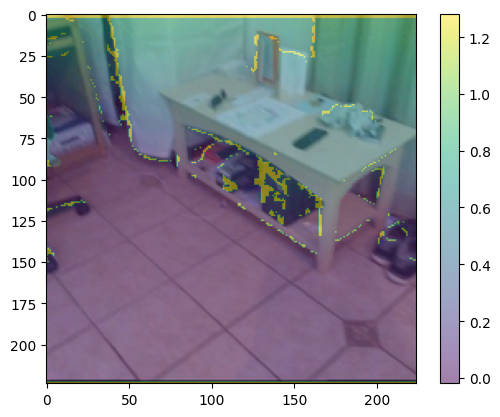

In [26]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.imshow(pts, alpha=0.5)
plt.colorbar()

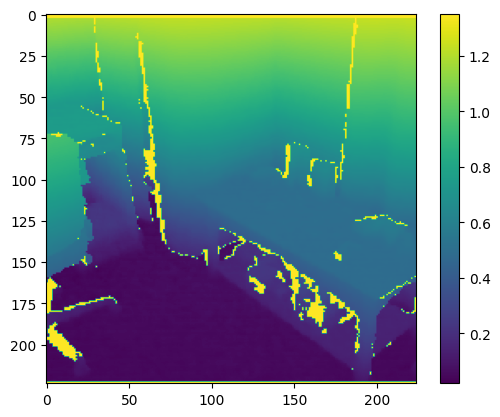

In [ ]:
plt.imshow(tensor_to_plot(view1['depthmap'][0]))
plt.colorbar()

In [ ]:
import numpy as np

In [ ]:
a = np.array([1,2,5,7,10,14])

def sigmoid(z):
    return 1/(1 + np.exp(-z))

a, np.log(a), sigmoid(np.log(a))